In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from statistics import mode

from sklearn import datasets, preprocessing 
from sklearn.model_selection import train_test_split

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector

In [2]:
iris = datasets.load_iris()
feature_labels = iris.feature_names
class_labels = iris.target_names

X = iris.data
y = np.array([iris.target])
M = 4

print("Features: ", feature_labels)
print("Classes: ", class_labels)

Features:  ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Classes:  ['setosa' 'versicolor' 'virginica']


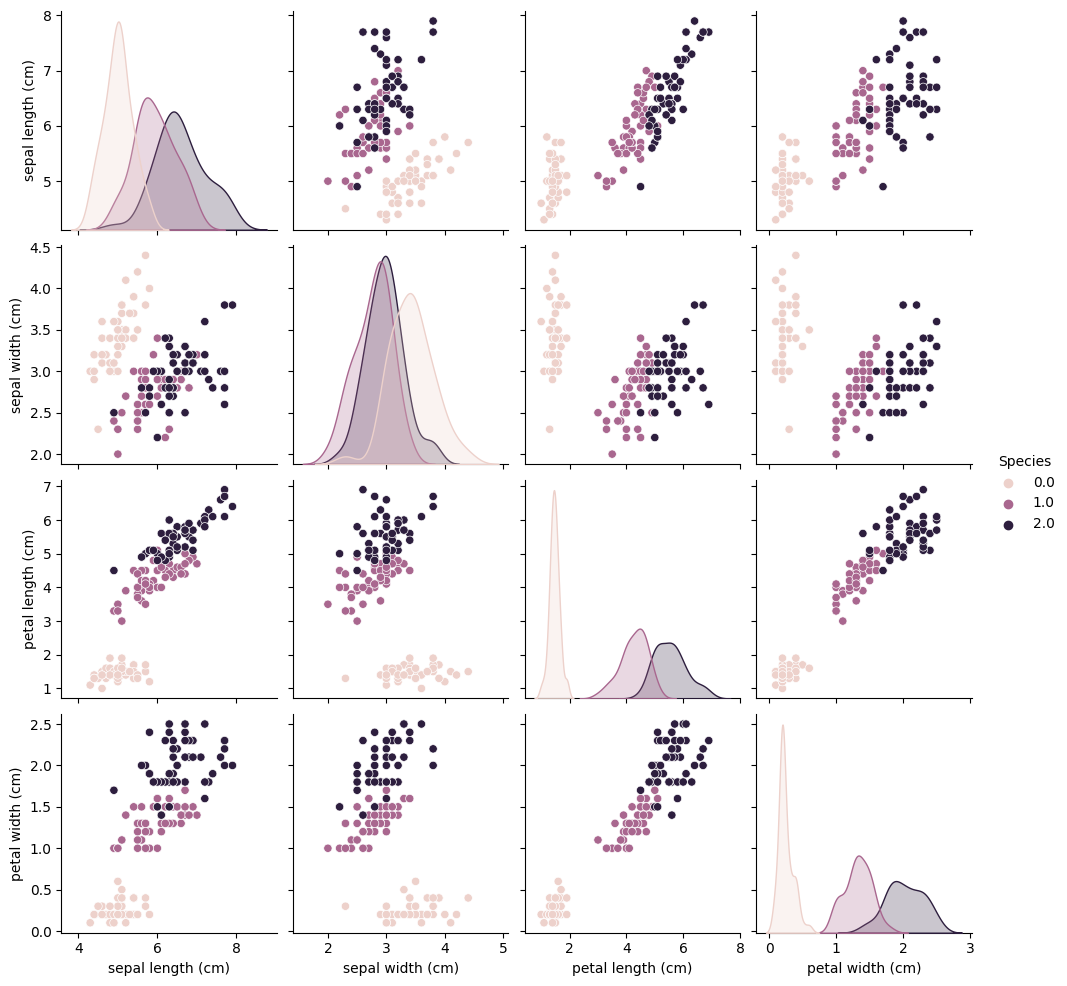

In [3]:
df = pd.DataFrame(data = np.concatenate((X, y.T), axis = 1), columns = feature_labels[0:M] + ["Species"])
sns.pairplot(df, hue = 'Species')

In [4]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
min_max_scaler.fit(X)
X_normalized = min_max_scaler.transform(X)

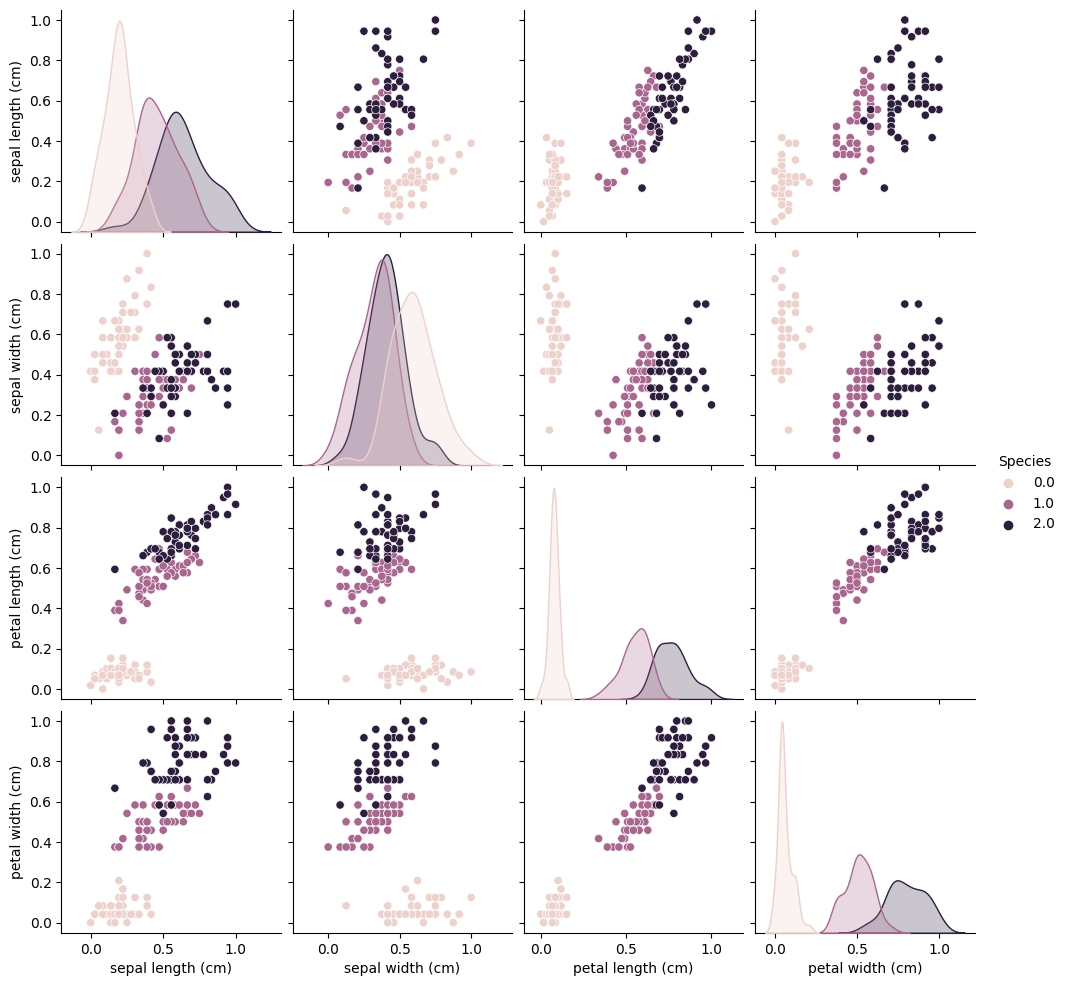

In [5]:
df2 = pd.DataFrame(data = np.concatenate((X_normalized, y.T), axis = 1), columns = feature_labels[0:M] + ["Species"])
sns.pairplot(df2, hue = 'Species')

In [6]:
N_train = 100

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y[0], train_size=N_train)

In [7]:
test_index = int(np.random.rand()*len(X_test)) 
phi_test = X_test[test_index]

for i in range(M):
    phi_i = [np.sqrt(phi_test[i]), np.sqrt(1- phi_test[i])]
    if i == 0:
        phi = phi_i
    else:
        phi = np.kron(phi_i, phi)    

print('Valid statevector: ', Statevector(phi).is_valid())

Valid statevector:  True


In [8]:
N = int(np.ceil(np.log2(N_train)))
psi = np.zeros(2**(M + N))

for i in range(N_train):
    i_vec = np.zeros(2**N)
    i_vec[i] = 1

    x = X_train[i, :]
    for j in range(M):
        dummy = [np.sqrt(x[j]), np.sqrt(1- x[j])]
        if j == 0:
            x_vec = dummy
        else:
            x_vec = np.kron(dummy, x_vec)
    psi_i = np.kron(x_vec, i_vec)
    psi += psi_i
psi /= np.sqrt(N_train)

assert Statevector(psi).is_valid(), "The statevector is not square-normalized."

In [9]:
index_reg = QuantumRegister(N, 'i')
train_reg = QuantumRegister(M, 'train')
test_reg = QuantumRegister(M, 'test')
p = QuantumRegister(1, 'similarity')

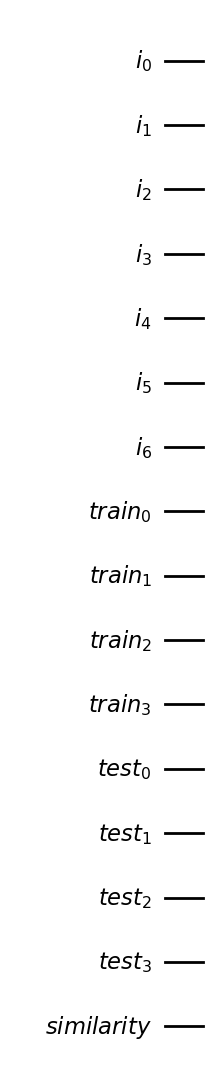

In [10]:
qknn = QuantumCircuit()

qknn.add_register(index_reg)
qknn.add_register(train_reg)
qknn.add_register(test_reg)
qknn.add_register(p)

qknn.draw('mpl') 

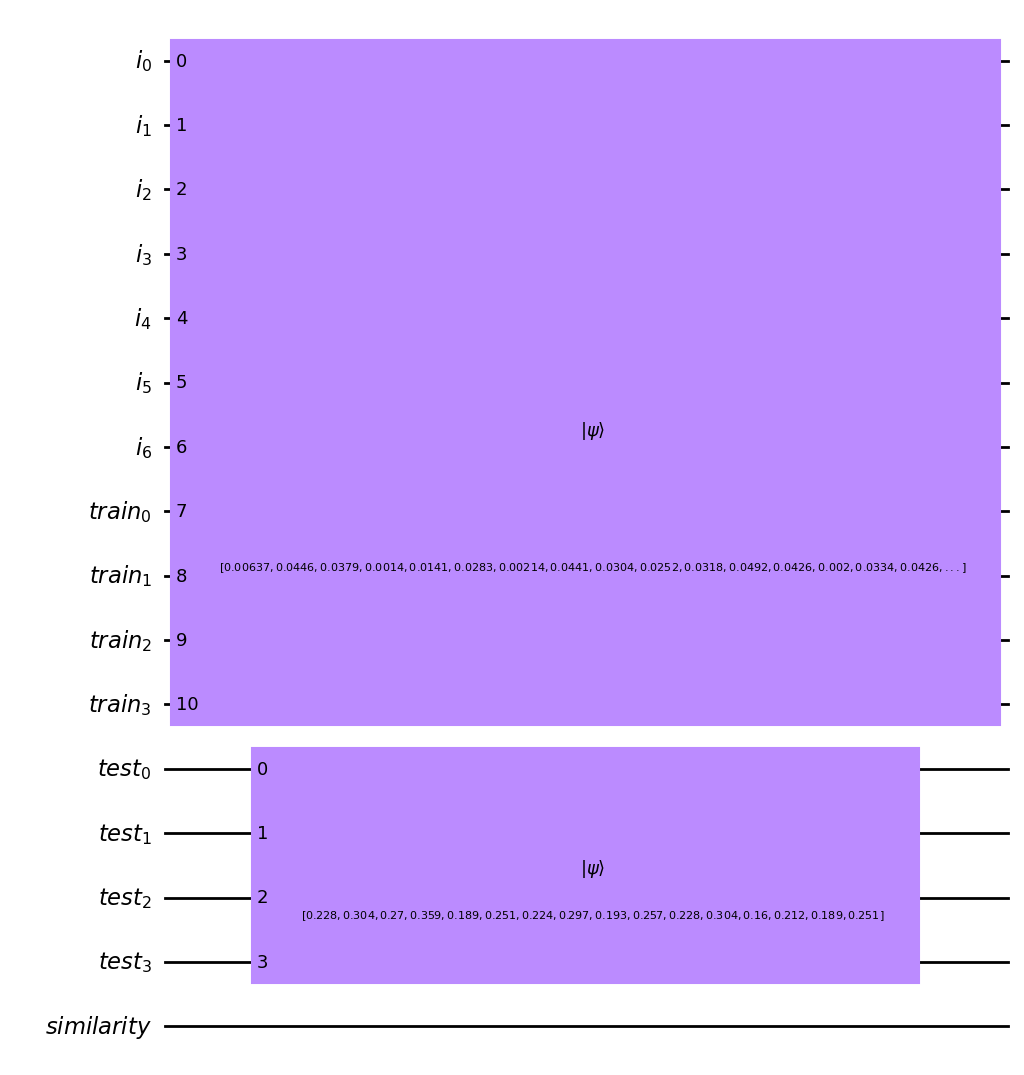

In [11]:
qknn.initialize(psi, index_reg[0:N] + train_reg[0:M])
qknn.initialize(phi, test_reg)

qknn.draw('mpl')

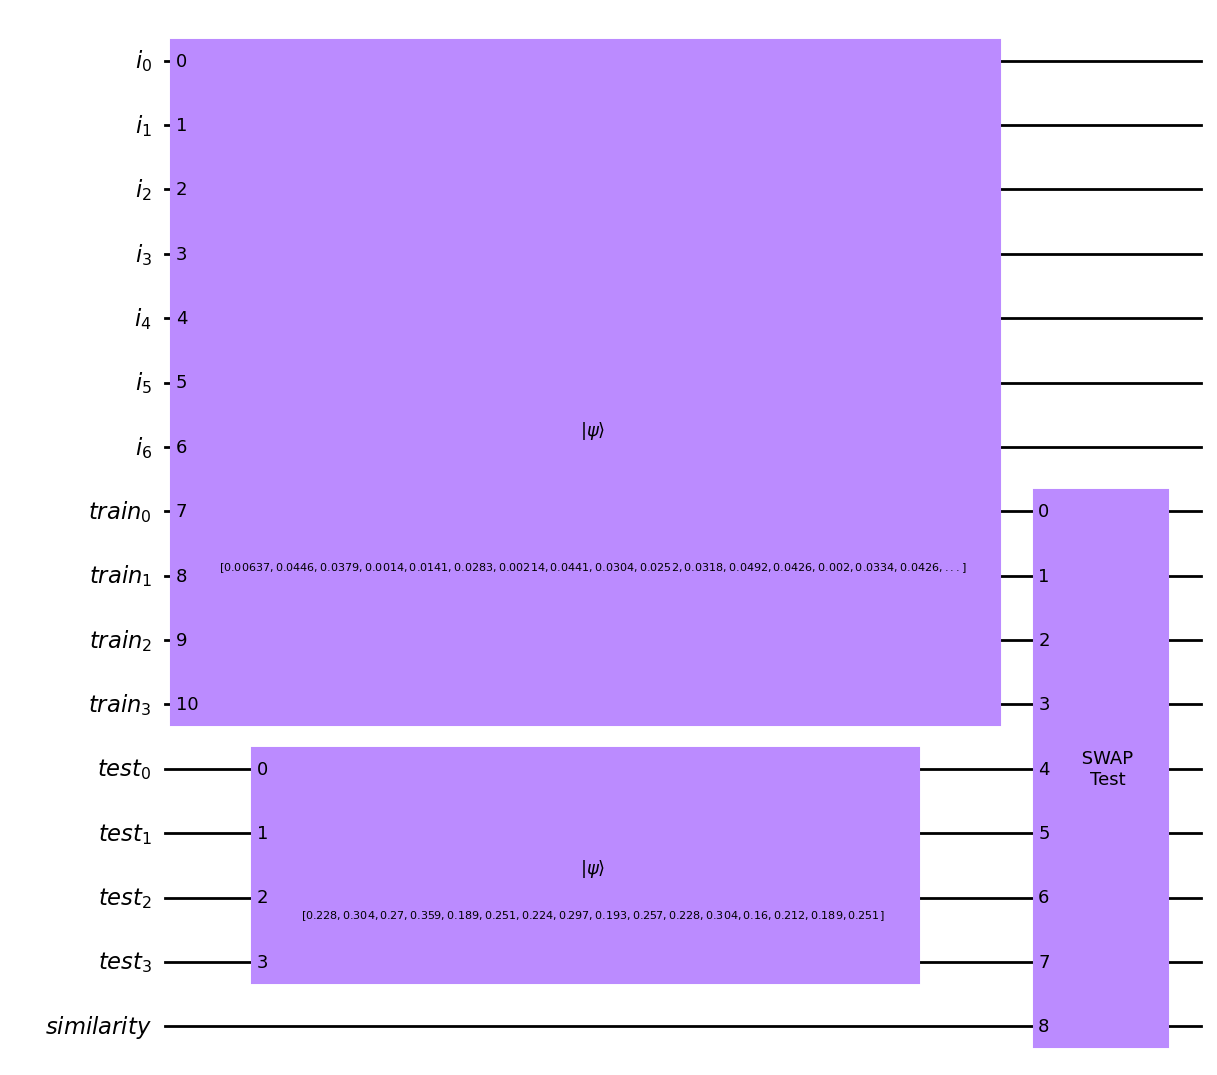

In [12]:
from usercode.modules import swap_test

qknn.append(swap_test(M), train_reg[0:M] + test_reg[0:M] + [p[0]])

qknn.draw('mpl')

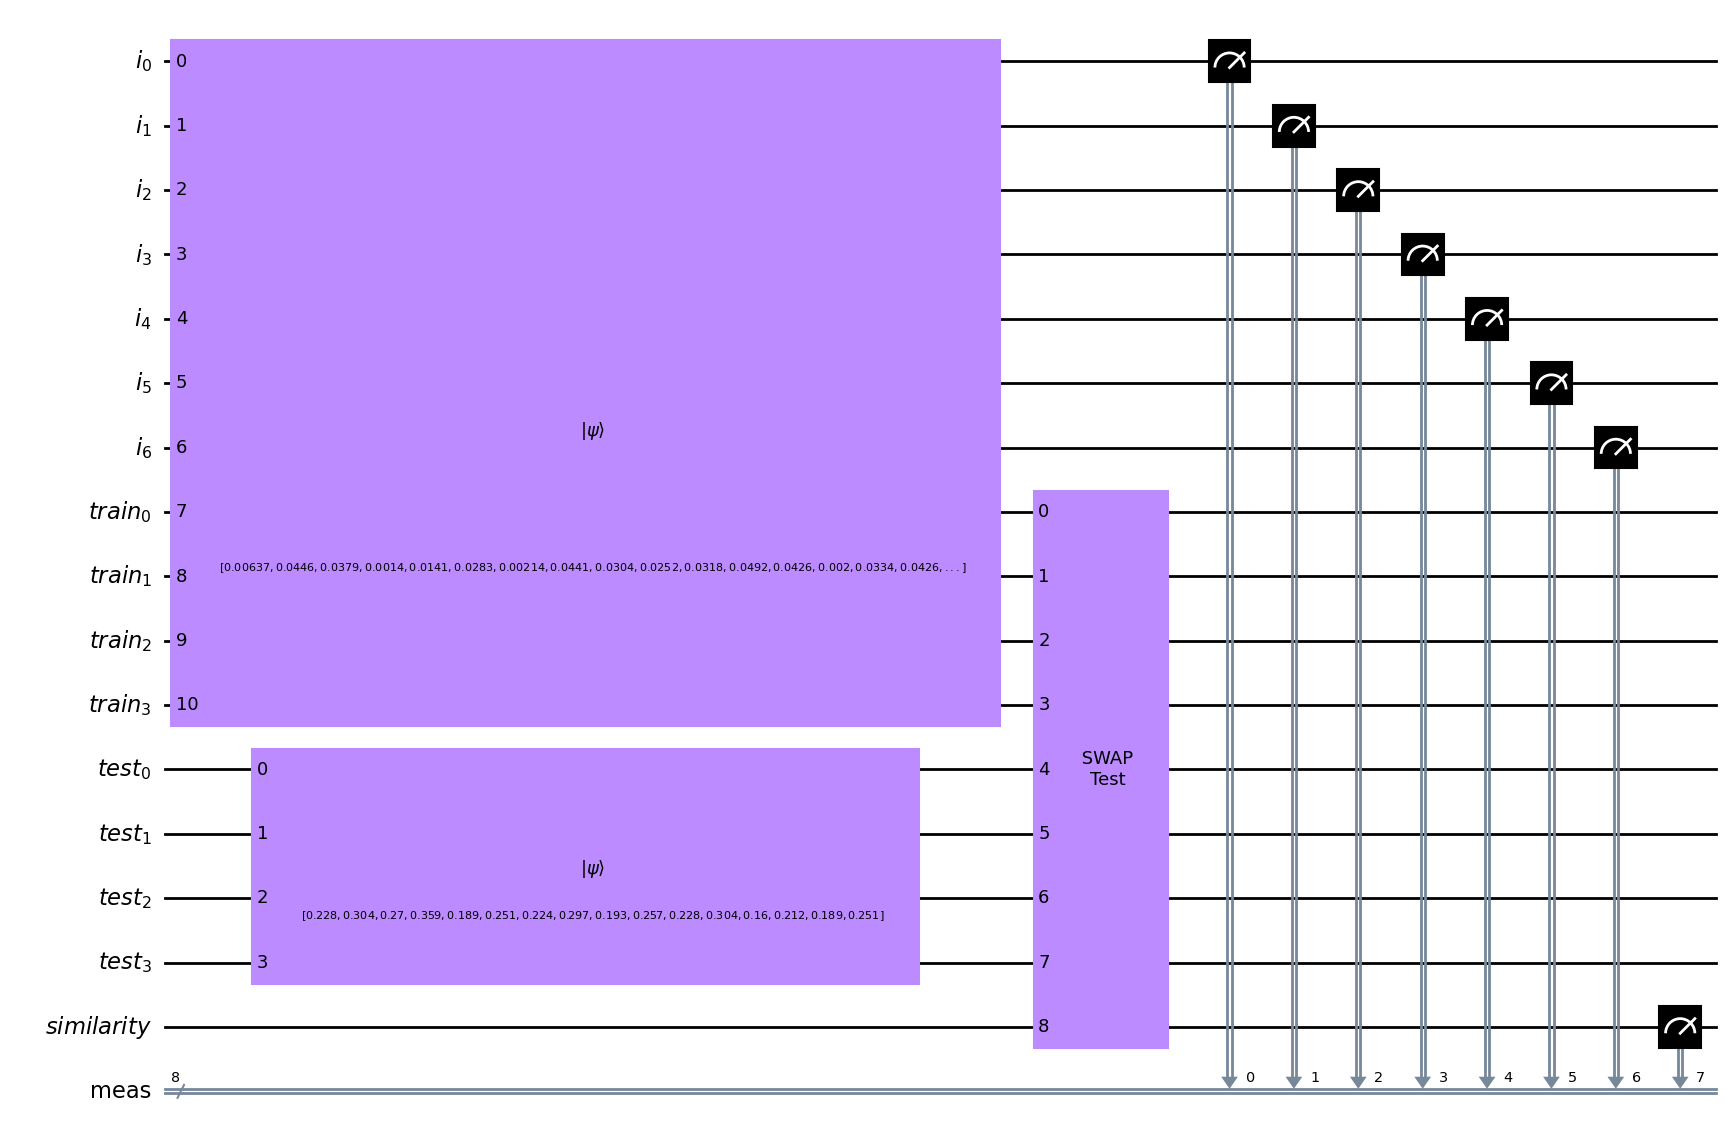

In [13]:
meas_reg_len = N + 1
meas_reg = ClassicalRegister(meas_reg_len, 'meas')
qknn.add_register(meas_reg)

qknn.measure(index_reg[0::] + p[0::], meas_reg)

qknn.draw('mpl', fold = -1)

In [14]:
backend = Aer.get_backend('qasm_simulator')
counts_knn = execute(qknn, backend, shots = 15000).result().get_counts()

In [15]:
result_arr = np.zeros((N_train, 3))
for count in counts_knn:
    i_dec = int(count[1::], 2)
    phase = int(count[0], 2)
    if phase == 0:
        result_arr[i_dec, 0] += counts_knn[count]
    else:
        result_arr[i_dec, 1] += counts_knn[count]

In [16]:
for i in range(N_train):        
    prob_1 = result_arr[i][1]/(result_arr[i][0] + result_arr[i][1])
    result_arr[i][2] = 1 - 2*prob_1

In [17]:
k = 10
k_min_dist_arr = result_arr[:, 2].argsort()[::-1][:k]

y_pred = mode(y_train[k_min_dist_arr])
y_exp = y_test[test_index]
print('Predicted class of the test sample is {}.'.format(y_pred))
print('Expected class of the test sample is {}.'.format(y_exp))

Predicted class of the test sample is 1.
Expected class of the test sample is 1.


In [19]:
def q_knn_module(test_index, psi, k=10):
    phi_test = X_test[test_index]

    for i in range(M):
        phi_i = [np.sqrt(phi_test[i]), np.sqrt(1- phi_test[i])]
        if i == 0:
            phi = phi_i
        else:
            phi = np.kron(phi, phi_i)    

    qknn = QuantumCircuit()

    qknn.add_register(index_reg)
    qknn.add_register(train_reg)
    qknn.add_register(test_reg)
    qknn.add_register(p)

    qknn.initialize(psi, index_reg[0:N] + train_reg[0:M])

    qknn.initialize(phi, test_reg)

    qknn.append(swap_test(M), train_reg[0:M] + test_reg[0:M] + [p[0]])

    meas_reg_len = N+1
    meas_reg = ClassicalRegister(meas_reg_len, 'meas')
    qknn.add_register(meas_reg)

    qknn.measure(index_reg[0::] + p[0::], meas_reg)

    backend = Aer.get_backend('qasm_simulator')
    counts_knn = execute(qknn, backend, shots = 10000).result().get_counts()

    result_arr = np.zeros((N_train, 3))
    for count in counts_knn:
        i_dec = int(count[1::], 2)
        phase = int(count[0], 2)
        if phase == 0:
            result_arr[i_dec, 0] += counts_knn[count]
        else:
            result_arr[i_dec, 1] += counts_knn[count]

    for i in range(N_train):        
        prob_1 = result_arr[i][1]/(result_arr[i][0] + result_arr[i][1])
        result_arr[i][2] = 1 - 2*prob_1

    k = 10
    k_min_dist_arr = result_arr[:, 2].argsort()[::-1][:k]

    y_pred = mode(y_train[k_min_dist_arr])
    y_exp = y_test[test_index]

    return y_pred, y_exp

y_pred_arr = []
y_exp_arr = [] 

for test_indx in range(len(X_test)):
    y_pred, y_exp = q_knn_module(test_indx, psi)
    y_pred_arr.append(y_pred)
    y_exp_arr.append(y_exp)

t = 0
f = 0
for i in range(len(X_test)):
    if y_pred_arr[i] == y_exp_arr[i]:
        t += 1
    else:
        f += 1

print('Model accuracy is {}%.'.format(t/(t+f) *100))